# k-Means法
- クラスタリングのアルゴリズム
- 教師なし学習
- 特徴量行列$\textbf{X}$とクラスタ数$k$が入力として与えられる
- $\textbf{X}$の各サンプル$\textbf{x}_i$から構成される点群を$k$個の点のかたまりに分類

## k-Meansのアルゴリズム

### アルゴリズムの概要
- 各点$\textbf{x}_i$にランダムにクラスタを割り振る
- 収束するまで以下を繰り返す
    1. 各クラスタの重心を計算
    2. 各点について、計算された重心からの距離を計算し、距離が一番近いクラスタに割りあて直す

収束条件: 点のクラスタへの所属情報が変化しない　or 所属情報の変化が一定の割合以下

わかりやすいVisualizationは[こちら](http://web.stanford.edu/class/ee103/visualizations/kmeans/kmeans.html)

### 距離・重心の計算
距離としてユークリッド距離を採用。

$j$番目のクラスタに属する点のインデックスの集合を$I_j$とすると、クラスタの重心$G_j$は
$$
G_j = \frac{1}{|I_j|}\sum_{i \in I_j}\textbf{x}_i
$$

### 実装上での工夫

具体例として、特徴量行列`X`と各点のクラスタへの所属`labels`を考える。

インデックシングをうまく利用すると簡単に重心が求まる。

In [1]:
import numpy as np

X = np.array([[1, 2],
                        [2, 3],
                        [3, 4],
                        [4, 5],
                        [5, 6],
                        [6, 7],
                        [7, 9]])

labels = np.array([0, 1, 2, 0, 1, 2, 0])

In [2]:
# クラスタ0に関する点のみを取り出す
X[labels == 0, :]

array([[1, 2],
       [4, 5],
       [7, 9]])

In [3]:
# クラスタ0の重心の計算
X[labels == 0, :].mean(axis=0)

array([4.        , 5.33333333])

次に、クラスタの中心`cluster_centers`が次のように与えられたとする。

In [4]:
cluster_centers = np.array([[1, 1],
                                                 [2, 2],
                                                 [3, 3]])

３つの中心から`X`の7点までの距離の2乗は次のように一気に計算できる。

In [10]:
((X[:, :, np.newaxis]
   - cluster_centers.T[np.newaxis, :, :])**2).sum(axis=1)

array([[  1,   1,   5],
       [  5,   1,   1],
       [ 13,   5,   1],
       [ 25,  13,   5],
       [ 41,  25,  13],
       [ 61,  41,  25],
       [100,  74,  52]])

この配列の`[i, j]`成分は`X[i, :]`と`cluster_centers[j, :]`の距離になる。

この計算を処理を分けて整理する。

In [11]:
p = X[:, :, np.newaxis] # X[i, j]をp[i, j, 0]に格納
q = cluster_centers.T[np.newaxis, :, :]　# cluster_centers[k, l]をq[0, l, k]に格納
r = (p - q)**2 
s = r.sum(axis=1)

各入力点がどのクラスタの中心に一番近いかというラベルを取得するには横方向に`argmin`を取ればよい。

In [13]:
s.argmin(axis=1)

array([0, 1, 2, 2, 2, 2, 2])

## 実装

In [14]:
import numpy as np
import itertools

class KMeans:
    def __init__(self, n_clusters, max_iter=1000, random_seed=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)
    
    def fit(self, X):
        cycle = itertools.cycle(range(self.n_clusters))
        self.labels_ = np.fromiter(
                itertools.islice(cycle, X.shape[0]), dtype=np.int)
        self.random_state.shuffle(self.labels_)
        labels_prev = np.zeros(X.shape[0])
        count = 0
        self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))
        while (not (self.labels_ == labels_prev).all() # すべての点で割りあてられたクラスタが前回の割りあてと異なるとき
                   and count < self.max_iter):
            # クラスタ重心の計算
            for i in range(self.n_clusters):
                XX = X[self.labels_ == i, :]
                self.cluster_centers_[i, :] = XX.mean(axis=0)
            # 各点のクラスタ重心までの距離の計算
            dist = ((X[:, :, np.newaxis]
                          - self.cluster_centers_.T[np.newaxis, :, :])
                           ** 2).sum(axis=1)
            labels_prev = self.labels_
            self.labels_ = dist.argmin(axis=1)
            count += 1
            
    def predict(self, x):
        dist = ((X[:, :, np.newaxis]
                          - self.cluster_centers_.T[np.newaxis, :, :])
                           ** 2).sum(axis=1)
        labels = dist.argmin(axis=1)
        return labels

## 人口データへの適用

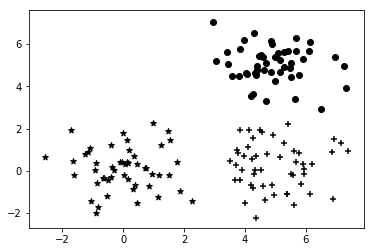

In [16]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
points1 = np.random.randn(50, 2)
points2 = np.random.randn(50, 2) + np.array([5, 0])
points3 = np.random.randn(50, 2) + np.array([5, 5])

points = np.r_[points1, points2, points3]
np.random.shuffle(points)

model = KMeans(3)
model.fit(points)

markers = ["+", "*", "o"]

for i in range(3):
    p = points[model.labels_ == i, :]
    plt.scatter(p[:, 0], p[:, 1], color="k", marker=markers[i])

plt.show()

## 参考
- 「機械学習のエッセンス」 加藤公一